In [2]:
import sys
import pybind11

sys.path.append("./build/")   # add build/ to Python module search path
import simulator
import numpy as np
import matplotlib.pyplot as plt
import time

In [23]:
"""
py::arg("rows"),
py::arg("cols"),
py::arg("state") = "RANDOM",
py::arg("K") = 1,
py::arg("k_BT") = 5,
py::arg("h") = 0,
py::arg("seed") = time(0),
py::arg("file_name") = "output.txt
"""
sim = simulator.MCIsing(100, 100, state="UP", seed=42, file_name="test.txt", h=0, k_BT=5)

In [24]:
sim.initialize(state="UP")
sim_history = sim.run_numpy_output(500)

In [25]:
energy = sim.get_energy_record()
magnetization = sim.get_magnetization_record()

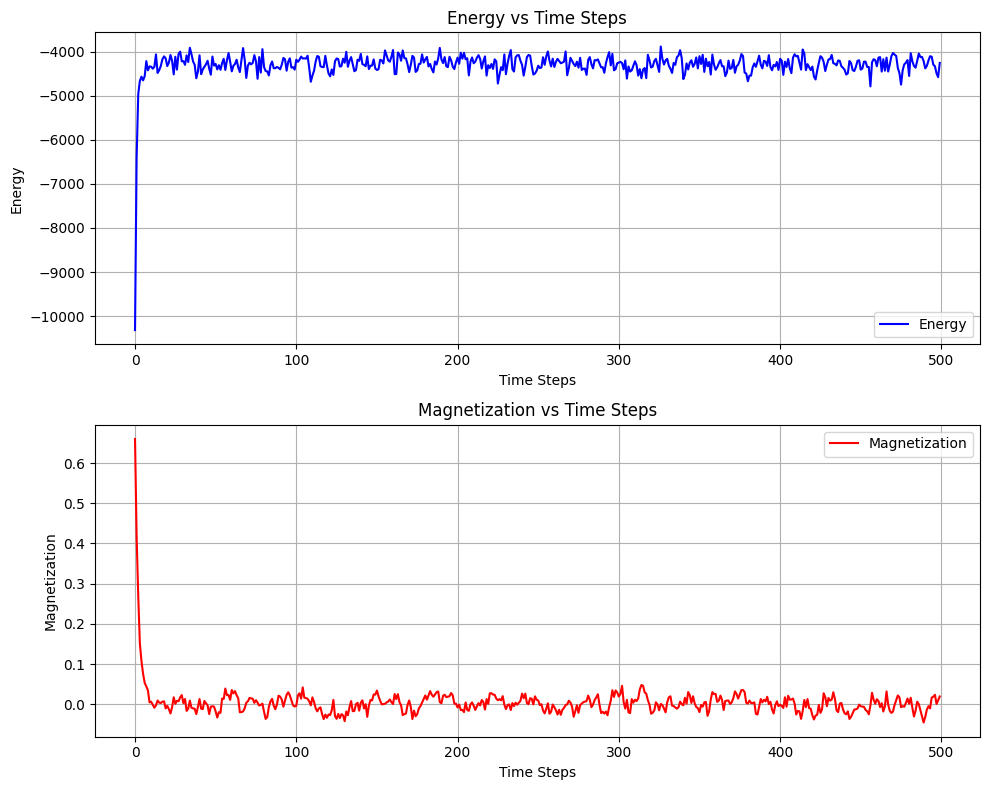

In [26]:
# Ploting the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(energy, label='Energy', color='blue')
ax1.set_title('Energy vs Time Steps')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Energy')
ax1.legend()
ax1.grid()
ax2.plot(magnetization, label='Magnetization', color='red')
ax2.set_title('Magnetization vs Time Steps')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Magnetization')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()
